A notebook to begin the development of a GPU version of Richardson-Lucy deconvolution.

In [1]:
# load our tools
%load_ext line_profiler
%matplotlib inline
from numba import njit, jit
from dphplotting import display_grid

# from accelerate import cuda, profiler
import numba
import numba.cuda

In [2]:
# we've changed the following file so that we only have the "matlab" implementation.
# %load ../decon.py
#!/usr/bin/env python
# decon.py
"""
Functions that actually perform the deconvolution.

Copyright (c) 2016, David Hoffman
"""

import numpy as np

try:
    import pyfftw
    from pyfftw.interfaces.numpy_fft import fftshift, ifftshift, fftn, ifftn, rfftn, irfftn

    # Turn on the cache for optimum performance
    pyfftw.interfaces.cache.enable()
except ImportError:
    from numpy.fft import fftshift, ifftshift, fftn, ifftn, rfftn, irfftn
from dphutils import fft_pad
from pyDecon.utils import _prep_img_and_psf, _ensure_positive, _zero2eps
import scipy.signal.signaltools as sig
from scipy.signal import fftconvolve
from scipy.ndimage import convolve


def _get_fshape_slice(image, psf):
    """This is necessary for the fast Richardson-Lucy Algorithm"""
    s1 = np.array(image.shape)
    s2 = np.array(psf.shape)
    assert (s1 >= s2).all()
    shape = s1 + s2 - 1
    # Speed up FFT by padding to optimal size for FFTPACK
    fshape = [sig.fftpack.helper.next_fast_len(int(d)) for d in shape]
    fslice = tuple([slice(0, int(sz)) for sz in shape])
    return fshape, fslice


def _rl_core_matlab(image, otf, psf, u_t, **kwargs):
    """The core update step of the RL algorithm

    This is a fast but inaccurate version modeled on matlab's version
    One improvement is to pad everything out when the shape isn't
    good for fft."""
    reblur = irfftn(otf * rfftn(u_t, u_t.shape, **kwargs), u_t.shape, **kwargs)
    reblur = _zero2eps(reblur)
    im_ratio = image / reblur  # _zero2eps(array(0.0))
    estimate = irfftn(
        np.conj(otf) * rfftn(im_ratio, im_ratio.shape, **kwargs), im_ratio.shape, **kwargs
    )
    # The below is to compensate for the slight shift that using np.conj
    # can introduce verus actually reversing the PSF. See notebooks for
    # details.
    for i, (s, p) in enumerate(zip(image.shape, psf.shape)):
        if s % 2 and not p % 2:
            estimate = np.roll(estimate, 1, i)
    estimate = _ensure_positive(estimate)
    return u_t * estimate  # / (1 + np.sqrt(np.finfo(u_t.dtype).eps))


eps = np.finfo(float).eps


def _rl_accelerate(g_tm1, g_tm2, u_t, u_tm1, u_tm2, prediction_order):
    """Biggs-Andrews Acceleration

    .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image
    Restoration Algorithms. Applied Optics 1997, 36 (8), 1766."""
    # TODO: everything here can be wrapped in ne.evaluate
    alpha = (g_tm1 * g_tm2).sum() / ((g_tm2**2).sum() + eps)
    alpha = max(min(alpha, 1), 0)
    # if alpha is positive calculate predicted step
    if alpha:
        # first order correction
        h1_t = u_t - u_tm1
        u_tp1 = u_t + alpha * h1_t
        if prediction_order > 1:
            # second order correction
            h2_t = u_t - 2 * u_tm1 + u_tm2
            u_tp1 = u_tp1 + alpha**2 / 2 * h2_t
        return u_tp1
    else:
        return u_t


def richardson_lucy_cpu(image, psf, iterations=10, prediction_order=1, init="matlab", **kwargs):
    """
    Richardson-Lucy deconvolution.

    Parameters
    ----------
    image : ndarray
       Input degraded image (can be N dimensional).
    psf : ndarray
       The point spread function. Assumes that it has no background
    iterations : int
       Number of iterations. This parameter plays the role of
       regularisation.
    prediction_order : int (0, 1 or 2)
        Use Biggs-Andrews to accelerate the algorithm [2] default is 1
    core_type : str
        Type of core to use (see Notes)
    init : str
        How to initialize the deconvolution (see Notes)

    Returns
    -------
    im_deconv : ndarray
       The deconvolved image.

    Examples
    --------

    Notes
    -----
    This algorithm can use a variety of cores to calculate the update step [1].
    The update step basically consists of two convolutions which can be
    performed in a few different ways. The "direct" core uses direct
    convolution to calculate them and is painfully slow but is included for
    completeness. The "accurate" core uses `fftconvolve` to properly and
    quickly calculate the convolution. "fast" optimizes "accurate" by only
    performing the FFTs on the PSF _once_. The "matlab" core is based on the
    MatLab implementation of Richardson-Lucy which speeds up the convolution
    steps by avoiding padding out both data and psf to avoid the wrap around
    effect of the fftconvolve. This approach is generally accurate because the
    psf is generally very small compared to data but will not give exactly the
    same results as "accurate" or "fast" and should not be used for large or
    complicated PSFs. The "matlab" routine also avoids the tapering effect
    implicit in fftconvolve and should be used whenever any of the image
    extends to the edge of data.

    The algorithm can also be initilized in two ways: using the original image
    ("matlab") or using a constant array the same size of the image filled with
    the mean value of the image ("mean"). The advantage to starting with the
    image is that you need fewer iterations to get a good result. However,
    the disadvantage is that if there original image has low SNR the result
    will be severly degraded. A good rule of thumb is that if the SNR is low
    (SNR < 10) that `init="mean"` be used and double the number of iterations.

    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
    .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image
    Restoration Algorithms. Applied Optics 1997, 36 (8), 1766.

    """
    # TODO: Make sure that data is properly padded for fast FFT numbers.
    # checked against matlab on 20160805 and agrees to within machine precision
    image, psf = _prep_img_and_psf(image, psf)
    # choose core
    core = _rl_core_matlab
    # set up the proper dict for the right core
    if core is _rl_core_matlab:
        if psf.shape != image.shape:
            # its been assumed that the background of the psf has already been
            # removed and that the psf has already been centered
            psf = fft_pad(psf, image.shape, mode="constant")
        otf = rfftn(ifftshift(psf))
        core_dict = dict(image=image, otf=otf, psf=psf)
    else:
        raise RuntimeError("{} is not a valid core".format(core))
    # initialize variable for iterations
    # previous estimate
    u_tm1 = u_tm2 = None
    if init == "matlab":
        core_dict["u_t"] = u_t = image
    else:
        # current estimate, for the initial estimate we use the mean of the
        # data this promotes a smooth solution and helps to reduce noise.
        core_dict["u_t"] = u_t = np.ones_like(image) * image.mean()
    # previous difference
    g_tm1 = g_tm2 = None
    for i in range(iterations):
        # if prediction is requested perform it
        if prediction_order and g_tm2 is not None and u_tm2 is not None:
            # need to save prediction as intermediate value
            y = _rl_accelerate(g_tm1, g_tm2, u_t, u_tm1, u_tm2, prediction_order)
        else:
            y = u_t
        # update estimate and ensure positive
        core_dict["u_t"] = _ensure_positive(y)
        # call the update function
        u_tp1 = core(**core_dict, **kwargs)
        # update
        # update g's
        g_tm2 = g_tm1
        # this is where the magic is, we need to compute from previous step
        # which may have been augmented by acceleration
        g_tm1 = u_tp1 - y
        # now move u's along
        # Here we don't want to update with accelerated version.
        # why not? is this a mistake?
        u_t, u_tm1, u_tm2 = u_tp1, u_t, u_tm1

    # return everything
    return dict(u_t=u_t, u_tm1=u_tm1, u_tm2=u_tm2, g_tm1=g_tm1, g_tm2=g_tm2)

In [3]:
# this one has been changed too, so that it doesn't automatically save the generated data
# %load "../fixtures/2D Test Fake Data/gen_rl_example.py"
#!/usr/bin/env python
# gen_rl_example.py
"""
A short script to generate and output example data for the RL algorithm

Copyright (c) 2016, David Hoffman
"""


def gen_data():
    print("Generating the data ...")
    x = np.linspace(-2.5, 2.5, 64, True)
    kernel = np.exp(-(x**2))
    kernel = kernel[np.newaxis] * kernel[:, np.newaxis]
    # normalize kernel
    k_norm = kernel / kernel.sum()
    # make signal
    x = np.linspace(-10, 10, 1024)
    signal = 5.0 * np.logical_and(x < 3, x > -3)
    signal = signal[np.newaxis] * signal[:, np.newaxis]
    blurred = convolve(signal, k_norm, mode="reflect")
    blurred = _ensure_positive(blurred)
    kernel = _ensure_positive(kernel)
    # save ground truth images
    # add some noise to both
    print("Add noise ...")
    np.random.seed(12345)
    blurred[blurred < 0] = 0
    blurred_noisy = np.random.poisson(blurred) + np.random.randn(*blurred.shape) ** 2
    kernel[kernel < 0] = 0
    psf = np.random.poisson(kernel * 100) + np.random.randn(*kernel.shape) ** 2
    psf /= psf.sum()
    return signal, blurred, kernel, blurred_noisy, psf

In [4]:
# make the shitty data
signal, blurred, kernel, blurred_noisy, psf = gen_data()

Generating the data ...
Add noise ...


In [5]:
# test run
decon = richardson_lucy_cpu(blurred_noisy, psf, init="mean")

(<matplotlib.figure.Figure at 0x1f2240d5f28>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F2240C26D8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001F2241C9A20>], dtype=object))

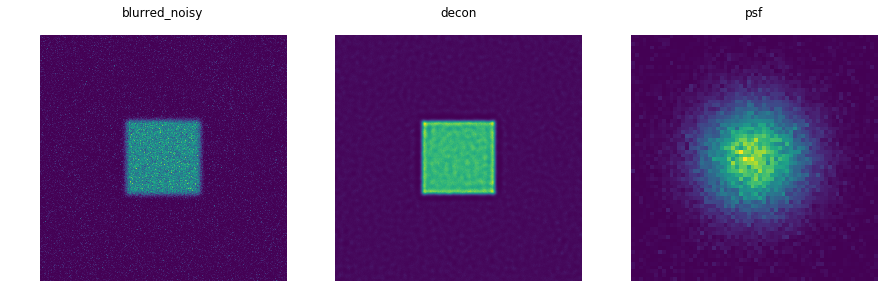

In [6]:
# display for comparison purposes
display_grid(dict(decon=decon["u_t"], blurred_noisy=blurred_noisy, psf=psf), figsize=5)

In [7]:
# profile run
%lprun -f richardson_lucy_cpu -f _rl_accelerate -f _rl_core_matlab richardson_lucy_cpu(blurred_noisy, psf, init="mean")

```
Timer unit: 4.10548e-07 s

Total time: 0.778752 s
File: <ipython-input-19-bbf4a11b5ce6>
Function: _rl_core_matlab at line 39

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    39                                           def _rl_core_matlab(image, otf, psf, u_t, **kwargs):
    40                                               """The core update step of the RL algorithm
    41                                           
    42                                               This is a fast but inaccurate version modeled on matlab's version
    43                                               One improvement is to pad everything out when the shape isn't
    44                                               good for fft."""
    45        10       772121  77212.1     40.7      reblur = irfftn(otf * rfftn(u_t, u_t.shape, **kwargs), u_t.shape, **kwargs)
    46        10        66786   6678.6      3.5      reblur = _zero2eps(reblur)
    47        10        95627   9562.7      5.0      im_ratio = image / reblur  # _zero2eps(array(0.0))
    48        10       434032  43403.2     22.9      estimate = irfftn(np.conj(otf) * rfftn(im_ratio, im_ratio.shape, **kwargs),
    49        10       383902  38390.2     20.2                        im_ratio.shape, **kwargs)
    50                                               # The below is to compensate for the slight shift that using np.conj
    51                                               # can introduce verus actually reversing the PSF. See notebooks for
    52                                               # details.
    53        30          282      9.4      0.0      for i, (s, p) in enumerate(zip(image.shape, psf.shape)):
    54        20           56      2.8      0.0          if s % 2 and not p % 2:
    55                                                       estimate = np.roll(estimate, 1, i)
    56        10        66065   6606.5      3.5      estimate = _ensure_positive(estimate)
    57        10        77989   7798.9      4.1      return u_t * estimate  # / (1 + np.sqrt(np.finfo(u_t.dtype).eps))

Total time: 0.15023 s
File: <ipython-input-19-bbf4a11b5ce6>
Function: _rl_accelerate at line 61

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    61                                           def _rl_accelerate(g_tm1, g_tm2, u_t, u_tm1, u_tm2, prediction_order):
    62                                               """Biggs-Andrews Acceleration
    63                                           
    64                                               .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image
    65                                               Restoration Algorithms. Applied Optics 1997, 36 (8), 1766."""
    66                                               # TODO: everything here can be wrapped in ne.evaluate
    67         8       162464  20308.0     44.4      alpha = (g_tm1 * g_tm2).sum() / ((g_tm2**2).sum() +
    68         8           91     11.4      0.0                                           eps)
    69         8          182     22.8      0.0      alpha = max(min(alpha, 1), 0)
    70                                               # if alpha is positive calculate predicted step
    71         8           19      2.4      0.0      if alpha:
    72                                                   # first order correction
    73         8        65114   8139.2     17.8          h1_t = u_t - u_tm1
    74         8       137993  17249.1     37.7          u_tp1 = u_t + alpha * h1_t
    75         8           48      6.0      0.0          if prediction_order > 1:
    76                                                       # second order correction
    77                                                       h2_t = (u_t - 2 * u_tm1 + u_tm2)
    78                                                       u_tp1 = u_tp1 + alpha**2 / 2 * h2_t
    79         8           15      1.9      0.0          return u_tp1
    80                                               else:
    81                                                   return u_t

Total time: 1.10769 s
File: <ipython-input-19-bbf4a11b5ce6>
Function: richardson_lucy_cpu at line 84

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    84                                           def richardson_lucy_cpu(image, psf, iterations=10, prediction_order=1, init="matlab", **kwargs):
    85                                               """
    86                                               Richardson-Lucy deconvolution.
    87                                           
    88                                               Parameters
    89                                               ----------
    90                                               image : ndarray
    91                                                  Input degraded image (can be N dimensional).
    92                                               psf : ndarray
    93                                                  The point spread function. Assumes that it has no background
    94                                               iterations : int
    95                                                  Number of iterations. This parameter plays the role of
    96                                                  regularisation.
    97                                               prediction_order : int (0, 1 or 2)
    98                                                   Use Biggs-Andrews to accelerate the algorithm [2] default is 1
    99                                               core_type : str
   100                                                   Type of core to use (see Notes)
   101                                               init : str
   102                                                   How to initialize the deconvolution (see Notes)
   103                                           
   104                                               Returns
   105                                               -------
   106                                               im_deconv : ndarray
   107                                                  The deconvolved image.
   108                                           
   109                                               Examples
   110                                               --------
   111                                           
   112                                               Notes
   113                                               -----
   114                                               This algorithm can use a variety of cores to calculate the update step [1].
   115                                               The update step basically consists of two convolutions which can be
   116                                               performed in a few different ways. The "direct" core uses direct
   117                                               convolution to calculate them and is painfully slow but is included for
   118                                               completeness. The "accurate" core uses `fftconvolve` to properly and
   119                                               quickly calculate the convolution. "fast" optimizes "accurate" by only
   120                                               performing the FFTs on the PSF _once_. The "matlab" core is based on the
   121                                               MatLab implementation of Richardson-Lucy which speeds up the convolution
   122                                               steps by avoiding padding out both data and psf to avoid the wrap around
   123                                               effect of the fftconvolve. This approach is generally accurate because the
   124                                               psf is generally very small compared to data but will not give exactly the
   125                                               same results as "accurate" or "fast" and should not be used for large or
   126                                               complicated PSFs. The "matlab" routine also avoids the tapering effect
   127                                               implicit in fftconvolve and should be used whenever any of the image
   128                                               extends to the edge of data.
   129                                           
   130                                               The algorithm can also be initilized in two ways: using the original image
   131                                               ("matlab") or using a constant array the same size of the image filled with
   132                                               the mean value of the image ("mean"). The advantage to starting with the
   133                                               image is that you need fewer iterations to get a good result. However,
   134                                               the disadvantage is that if there original image has low SNR the result
   135                                               will be severly degraded. A good rule of thumb is that if the SNR is low
   136                                               (SNR < 10) that `init="mean"` be used and double the number of iterations.
   137                                           
   138                                               References
   139                                               ----------
   140                                               .. [1] http://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
   141                                               .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image
   142                                               Restoration Algorithms. Applied Optics 1997, 36 (8), 1766.
   143                                           
   144                                               """
   145                                               # TODO: Make sure that data is properly padded for fast FFT numbers.
   146                                               # checked against matlab on 20160805 and agrees to within machine precision
   147         1        25757  25757.0      1.0      image, psf = _prep_img_and_psf(image, psf)
   148                                               # choose core
   149         1            6      6.0      0.0      core = _rl_core_matlab
   150                                               # set up the proper dict for the right core
   151         1            3      3.0      0.0      if core is _rl_core_matlab:
   152         1            7      7.0      0.0          if psf.shape != image.shape:
   153                                                       # its been assumed that the background of the psf has already been
   154                                                       # removed and that the psf has already been centered
   155         1        31010  31010.0      1.1              psf = fft_pad(psf, image.shape, mode='constant')
   156         1        86763  86763.0      3.2          otf = rfftn(ifftshift(psf))
   157         1           24     24.0      0.0          core_dict = dict(image=image, otf=otf, psf=psf)
   158                                               else:
   159                                                   raise RuntimeError("{} is not a valid core".format(core))
   160                                               # initialize variable for iterations
   161                                               # previous estimate
   162         1            3      3.0      0.0      u_tm1 = u_tm2 = None
   163         1            3      3.0      0.0      if init == "matlab":
   164                                                   core_dict["u_t"] = u_t = image
   165                                               else:
   166                                                   # current estimate, for the initial estimate we use the mean of the
   167                                                   # data this promotes a smooth solution and helps to reduce noise.
   168         1        27462  27462.0      1.0          core_dict["u_t"] = u_t = np.ones_like(image) * image.mean()
   169                                               # previous difference
   170         1            4      4.0      0.0      g_tm1 = g_tm2 = None
   171        11           53      4.8      0.0      for i in range(iterations):
   172                                                   # if prediction is requested perform it
   173        10           36      3.6      0.0          if prediction_order and g_tm2 is not None and u_tm2 is not None:
   174                                                       # need to save prediction as intermediate value
   175         8           34      4.2      0.0              y = _rl_accelerate(g_tm1, g_tm2, u_t, u_tm1, u_tm2,
   176         8       394778  49347.2     14.6                                 prediction_order)
   177                                                   else:
   178         2            4      2.0      0.0              y = u_t
   179                                                   # update estimate and ensure positive
   180        10        86251   8625.1      3.2          core_dict["u_t"] = _ensure_positive(y)
   181                                                   # call the update function
   182        10      1934268 193426.8     71.7          u_tp1 = core(**core_dict, **kwargs)
   183                                                   # update
   184                                                   # update g's
   185        10        15721   1572.1      0.6          g_tm2 = g_tm1
   186                                                   # this is where the magic is, we need to compute from previous step
   187                                                   # which may have been augmented by acceleration
   188        10        80208   8020.8      3.0          g_tm1 = u_tp1 - y
   189                                                   # now move u's along
   190                                                   # Here we don't want to update with accelerated version.
   191                                                   # why not? is this a mistake?
   192        10        15668   1566.8      0.6          u_t, u_tm1, u_tm2 = u_tp1, u_t, u_tm1
   193                                                   
   194                                               # return everything
   195         1           12     12.0      0.0      return dict(u_t=u_t, u_tm1=u_tm1, u_tm2=u_tm2, g_tm1=g_tm1, g_tm2=g_tm2)
```

It looks like the accelerate step takes 15% of the time and the actual core update takes 72% of the time. This means that we'll have to speed up both on the GPU to see any significant improvement.

Unfortunately, jitting the accelerate function doesn't win us a lot ...

In [8]:
# jitting this function doesn't seem to work well or speed up the calculation.
@njit
def _rl_accelerate_njit(g_tm1, g_tm2, u_t, u_tm1, u_tm2, prediction_order):
    """Biggs-Andrews Acceleration

    .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image
    Restoration Algorithms. Applied Optics 1997, 36 (8), 1766."""
    # TODO: everything here can be wrapped in ne.evaluate
    alpha = (g_tm1 * g_tm2).sum() / ((g_tm2**2).sum() + eps)
    alpha2 = max(min(alpha, 1), 0)
    # if alpha is positive calculate predicted step
    if alpha2:
        # first order correction
        h1_t = u_t - u_tm1
        u_tp1 = u_t + alpha2 * h1_t
        if prediction_order > 1:
            # second order correction
            h2_t = u_t - 2 * u_tm1 + u_tm2
            u_tp1 = u_tp1 + alpha2**2 / 2 * h2_t
        return u_tp1
    else:
        return u_t

In [9]:
np.allclose(
    _rl_accelerate(**decon, prediction_order=1), _rl_accelerate_njit(**decon, prediction_order=1)
)

True

In [10]:
(
    (
        _rl_accelerate(**decon, prediction_order=1)
        - _rl_accelerate_njit(**decon, prediction_order=1)
    )
    ** 2
).sum()

8.3885866207283481e-24

In [11]:
%timeit _rl_accelerate(**decon, prediction_order=1)
%timeit _rl_accelerate_njit(**decon, prediction_order=1)

10 loops, best of 3: 20.6 ms per loop
100 loops, best of 3: 17.9 ms per loop


Not much of a speed up at all...

In [15]:
_rl_accelerate_njit.inspect_types()

_rl_accelerate_njit (array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), int64)
--------------------------------------------------------------------------------
# File: <ipython-input-11-36ef1f1270be>
# --- LINE 2 --- 
# label 0
#   del g_tm1
#   del $0.3
#   del $0.4
#   del g_tm2
#   del $const0.7
#   del $0.8
#   del $0.9
#   del $0.11
#   del $0.10
#   del $0.5
#   del $0.12
#   del $0.13
#   del alpha
#   del $const0.17
#   del $0.15
#   del $const0.19
#   del $0.18
#   del $0.14
#   del $0.20

@njit

# --- LINE 3 --- 

def _rl_accelerate_njit(g_tm1, g_tm2, u_t, u_tm1, u_tm2, prediction_order):

    # --- LINE 4 --- 

    """Biggs-Andrews Acceleration

# --- LINE 5 --- 



    # --- LINE 6 --- 

    .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image

    # --- LINE 7 --- 

    Restoration Algorithms. Applied Optics 1997, 36 (8), 1766."""

    # --- LINE 8 --- 

    # TODO: everything here can be wrappe

This might be the problem.

In [12]:
# jitting this function doesn't seem to work well or speed up the calculation.
@njit
def _alpha_calc(g_tm1, g_tm2):
    numerator = 0.0
    denominator = 0.0
    g1 = g_tm1.ravel()
    g2 = g_tm2.ravel()
    for i in range(g1.size):
        numerator += g1[i] * g2[i]
        denominator += g2[i] ** 2
    return numerator / (denominator + eps)


@njit
def _rl_accelerate2(g_tm1, g_tm2, u_t, u_tm1, u_tm2, prediction_order):
    """Biggs-Andrews Acceleration

    .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image
    Restoration Algorithms. Applied Optics 1997, 36 (8), 1766."""
    # TODO: everything here can be wrapped in ne.evaluate
    alpha = (g_tm1 * g_tm2).sum() / ((g_tm2**2).sum() + eps)
    alpha = max(min(alpha, 1.0), 0.0)
    # if alpha is positive calculate predicted step
    if alpha:
        # first order correction
        u_tp1 = np.empty_like(u_t)
        for j in range(u_tp1.shape[0]):
            for i in range(u_tp1.shape[1]):
                h1_t = u_t[j, i] - u_tm1[j, i]
                u_tp1[j, i] = u_t[j, i] + alpha * h1_t
                if prediction_order > 1:
                    # second order correction
                    h2_t = u_t[j, i] - 2 * u_tm1[j, i] + u_tm2[j, i]
                    u_tp1[j, i] += alpha**2 / 2 * h2_t
        return u_tp1
    else:
        return u_t

In [13]:
%timeit _rl_accelerate(**decon, prediction_order=1)
%timeit _rl_accelerate_njit(**decon, prediction_order=1)
%timeit _rl_accelerate2(**decon, prediction_order=1)

10 loops, best of 3: 24.1 ms per loop
100 loops, best of 3: 17.7 ms per loop
The slowest run took 32.64 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 13.4 ms per loop


In [14]:
np.allclose(
    _rl_accelerate(**decon, prediction_order=1), _rl_accelerate2(**decon, prediction_order=1)
)

True

In [15]:
_rl_accelerate2.inspect_types()

_rl_accelerate2 (array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), int64)
--------------------------------------------------------------------------------
# File: <ipython-input-12-00451bd27627>
# --- LINE 13 --- 
# label 0
#   del g_tm1
#   del $0.3
#   del $0.4
#   del g_tm2
#   del $const0.7
#   del $0.8
#   del $0.9
#   del $0.11
#   del $0.10
#   del $0.5
#   del $0.12
#   del $0.13
#   del alpha
#   del $const0.17
#   del $0.15
#   del $const0.19
#   del $0.18
#   del $0.14
#   del $0.20

@njit

# --- LINE 14 --- 

def _rl_accelerate2(g_tm1, g_tm2, u_t, u_tm1, u_tm2, prediction_order):

    # --- LINE 15 --- 

    """Biggs-Andrews Acceleration

# --- LINE 16 --- 



    # --- LINE 17 --- 

    .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image

    # --- LINE 18 --- 

    Restoration Algorithms. Applied Optics 1997, 36 (8), 1766."""

    # --- LINE 19 --- 

    # TODO: everything here can be wrapped

So it looks like we can get about a ~1.55 speed up over the non-jitted version which isn't great.

Let's see if we can start building a GPU version

In [16]:
@numba.vectorize(["float32(float32, float32)", "float64(float64, float64)"], target="cuda")
def add_gpu(a, b):
    return a + b


@numba.vectorize(["float32(float32, float32)"], target="cuda")
def mult_gpu(a, b):
    return a * b


@numba.cuda.reduce
def sum_gpu(a, b):
    return a + b


@numba.cuda.jit
def mult_gpu_2d(a, b, c):
    x, y = numba.cuda.grid(2)
    if x < c.shape[0] and y < c.shape[1]:
        c[x, y] = a[x, y] * b[x, y]


@numba.cuda.jit
def add_gpu_2d(a, b, c):
    x, y = numba.cuda.grid(2)
    if x < c.shape[0] and y < c.shape[1]:
        c[x, y] = a[x, y] + b[x, y]

In [20]:
# excplicit cuda kernels are faster.
dg_tm1 = numba.cuda.to_device(decon["g_tm1"].astype(np.float32))
dg_tm2 = numba.cuda.to_device(decon["g_tm2"].astype(np.float32))
a = numba.cuda.device_array_like(dg_tm1)
print("numpy/cpu version", end="...")
%timeit (decon["g_tm1"] * decon["g_tm2"])
print("mult_gpu version", end="...")
%timeit b = mult_gpu(dg_tm1, dg_tm2)
print("mult_gpu version raveled", end="...")
%timeit b = mult_gpu(dg_tm1.ravel(), dg_tm2.ravel())
print("mult_gpu_2d version", end="...")
%timeit mult_gpu_2d[(16, 16), (32, 32)](dg_tm1, dg_tm2, a)

numpy/cpu version...100 loops, best of 3: 3.4 ms per loop
mult_gpu version...The slowest run took 6.65 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.86 ms per loop
mult_gpu version raveled...1000 loops, best of 3: 1.82 ms per loop
mult_gpu_2d version...1000 loops, best of 3: 218 µs per loop


In [21]:
print("numpy/cpu version", end="...")
%timeit decon["g_tm1"].sum()
print("mult_gpu.reduce version", end="...")
%timeit mult_gpu.reduce(dg_tm1.ravel())
print("sum_gpu version", end="...")
%timeit sum_gpu(dg_tm1.ravel())

numpy/cpu version...1000 loops, best of 3: 590 µs per loop
mult_gpu.reduce version...100 loops, best of 3: 9.66 ms per loop
sum_gpu version...The slowest run took 20.11 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 121 ms per loop


In [22]:
%timeit dg_tm1.copy_to_host().sum()

100 loops, best of 3: 2.87 ms per loop


I will need to test all of the above with a newer version of numba (0.30.1)

In [281]:
def _rl_accelerate_gpu(g_tm1, g_tm2):  # , u_t, u_tm1, u_tm2, prediction_order):
    """Biggs-Andrews Acceleration

    .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image
    Restoration Algorithms. Applied Optics 1997, 36 (8), 1766."""
    # TODO: everything here can be wrapped in ne.evaluate
    alpha = add_gpu.reduce(mult_gpu(g_tm1, g_tm2).ravel()) / (
        add_gpu.reduce(mult_gpu(g_tm2, g_tm2).ravel())
    )
    #     alpha = max(min(alpha, 1), 0)
    #     # if alpha is positive calculate predicted step
    #     if alpha:
    #         # first order correction
    #         h1_t = u_t - u_tm1
    #         u_tp1 = u_t + alpha * h1_t
    #         if prediction_order > 1:
    #             # second order correction
    #             h2_t = (u_t - 2 * u_tm1 + u_tm2)
    #             u_tp1 = u_tp1 + alpha**2 / 2 * h2_t
    #         return u_tp1
    #     else:
    #         return u_t
    return alpha

In [ ]:
# very rough beginnings of an actual core, need to check the convolve example for tips.
def _rl_core_matlab(image, otf, psf, u_t, **kwargs):
    """The core update step of the RL algorithm

    This is a fast but inaccurate version modeled on matlab's version
    One improvement is to pad everything out when the shape isn't
    good for fft."""
    # forward fft for image
    fft_u_t = cuda.fft.fft(u_t, u_t.shape)
    # kernel function to multiply two images
    fft_reblur = mult_gpu(otf, fft_u_t)
    # inverse fft
    reblur = cuda.fft.ifft(fft_reblur, u_t.shape, **kwargs)
    # add eps on gpu
    reblur = _zero2eps_gpu(reblur)
    im_ratio = image / reblur  # _zero2eps(array(0.0))
    estimate = irfftn(
        np.conj(otf) * rfftn(im_ratio, im_ratio.shape, **kwargs), im_ratio.shape, **kwargs
    )
    # The below is to compensate for the slight shift that using np.conj
    # can introduce verus actually reversing the PSF. See notebooks for
    # details.
    for i, (s, p) in enumerate(zip(image.shape, psf.shape)):
        if s % 2 and not p % 2:
            estimate = np.roll(estimate, 1, i)
    estimate = _ensure_positive(estimate)
    return u_t * estimate  # / (1 + np.sqrt(np.finfo(u_t.dtype).eps))